In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import renom as rm
from renom.cuda import set_cuda_active
from renom.optimizer import Adam

from renom_rg.api.regression.gcnn import GCNet
from renom_rg.api.utility.feature_graph import get_corr_graph, get_kernel_graph, get_dbscan_graph

np.random.seed(1984)

In [2]:
if rm.cuda.has_cuda():
    set_cuda_active(True)

In [3]:
batch_size = 16
epochs = 100
fc_unit = (100, 50)
channels = (10, 20, 20)
neighbors = 5
gamma = 0.1

In [4]:
boston_data = load_boston()

X = boston_data.data
y = boston_data.target.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
# feature_graph = get_corr_graph(X_train, neighbors)
# feature_graph = get_kernel_graph(X_train, neighbors, gamma)
feature_graph = get_dbscan_graph(X_train, neighbors)

In [6]:
%%time
network = GCNet(feature_graph=feature_graph, num_target=y_train.shape[1], neighbors=neighbors, fc_unit=fc_unit, channels=channels)
optimizer = Adam()

learning_curve = []
test_curve = []

for i in range(epochs):
    N = X_train.shape[0]
    perm = np.random.permutation(N)
    loss = 0
    bar = tqdm(range(N//batch_size))
    
    pred_train = []
    pred_true = []
    for j in bar:
        index = perm[j*batch_size:(j+1)*batch_size]
        train_batch_x = X_train[index].reshape(-1, 1, X_train.shape[1], 1)
        train_batch_y = y_train[index]

        # Loss function
        network.set_models(inference=False)
        with network.train():
            pred = network(train_batch_x)

            if rm.is_cuda_active():
                p = pred.as_ndarray()
            else:
                p = pred
            
            pred_train.extend(p.tolist())
            pred_true.extend(train_batch_y.tolist())
            l = rm.mse(pred, train_batch_y)

        # Back propagation
        grad = l.grad()

        # Update
        grad.update(optimizer)
        
        if rm.is_cuda_active():
            loss += l.as_ndarray()
        else:
            loss += l

        bar.set_description("epoch: {} loss: {}".format(i, l))
        bar.update(1)

    train_loss = loss / (N//batch_size)
    learning_curve.append(train_loss)

    # Validation
    network.set_models(inference=True)
    N = X_test.shape[0]
    
    pred = network(X_test.reshape(-1, 1, X_test.shape[1], 1))
    test_loss = rm.mse(pred, y_test)
    if rm.is_cuda_active():
        pred = pred.as_ndarray()
        test_loss = test_loss.as_ndarray()
    test_curve.append(test_loss)

#     print("epoch:{} train_loss: {} test_loss: {}".format(i, train_loss, test_loss))
#     print("epoch {} R2:{}".format(i, r2_score(y_test, pred)))

epoch: 96 loss: 2.2772679328918457: 100%|██████████| 25/25 [00:00<00:00, 60.75it/s]


epoch: 99 loss: 3.2915749549865723: 100%|██████████| 25/25 [00:00<00:00, 64.74it/s]

CPU times: user 1min 47s, sys: 3min 37s, total: 5min 25s
Wall time: 44.1 s


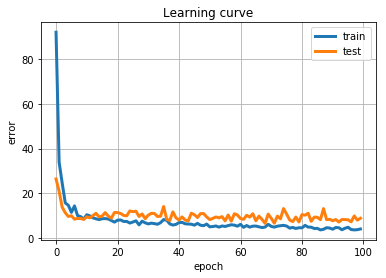

In [7]:
# Learning curve.
plt.plot(learning_curve, linewidth=3, label="train")
plt.plot(test_curve, linewidth=3, label="test")
plt.title("Learning curve")
plt.ylabel("error")
plt.xlabel("epoch")
plt.legend()
plt.grid()
plt.show()

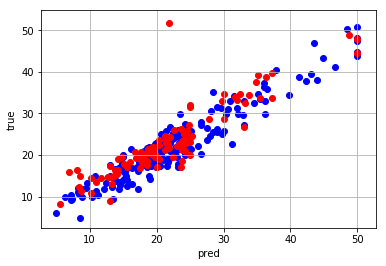

In [8]:
# true prediction plot.
plt.scatter(np.array(pred_true)[:200], np.array(pred_train)[:200], c="b")
plt.scatter(y_test, pred, c="r")
plt.ylabel("true")
plt.xlabel("pred")
plt.grid()
plt.show()